In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
from sklearn import tree
import scipy.stats as stat
#from helper import Helper
from urllib.parse import urlparse
import numpy as np
import pickle
import mlflow
import mlflow.sklearn
import scipy.stats as scs
import statsmodels.api as sm

import logging

import dvc.api

In [44]:
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

In [45]:
#Gwt url from DVC

path = r'C:\Users\Jakinda\Documents\Python Scripts\10Academy\ab_mlop\data\os.csv'
repo = r'C:\Users\Jakinda\Documents\Python Scripts\10Academy\ab_mlop'
version = 'v3'

data_url = dvc.api.get_url(

    path = path,
    repo = repo,
    rev = version

)

In [46]:
mlflow.set_experiment('ab_test')

In [47]:
data = pd.read_csv(data_url,sep=',')

In [48]:
mlflow.log_param("data_url", data_url)
mlflow.log_param("data_version", version)
mlflow.log_metric("input_rows", data.shape[0])
mlflow.log_metric("input_cols", data.shape[1])

In [49]:
target_name = "yes"
target = data[target_name]
data = data.drop(columns=target_name)

In [50]:
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size=0.30, random_state=42)

In [51]:
scaler = preprocessing.StandardScaler()
data_train_scaled = scaler.fit_transform(data_train)
data_train_scaled

array([[ 0.96387062,  0.77530212,  0.60093273,  0.18453256,  0.11316178],
       [ 0.96387062,  0.77530212,  0.60093273, -0.69352108,  0.11316178],
       [-1.03748365, -0.01130178, -2.02978585,  2.53771632,  0.11316178],
       ...,
       [ 0.96387062, -1.19120762, -1.85440461, -0.69352108,  0.11316178],
       [-1.03748365, -1.19120762,  0.60093273,  0.32502114,  0.11316178],
       [ 0.96387062, -1.19120762, -0.80211718, -0.69352108,  0.11316178]])

In [52]:
data_test_scaled = scaler.transform(data_test)
data_test_scaled

array([[ 0.96387062,  1.56190601, -2.02978585,  0.36014329,  0.11316178],
       [ 0.96387062,  1.16860406,  1.65322015, -0.69352108,  0.11316178],
       [-1.03748365, -1.19120762,  0.60093273, -0.69352108,  0.11316178],
       ...,
       [-1.03748365,  0.77530212,  0.9516952 , -0.69352108,  0.11316178],
       [ 0.96387062, -0.01130178, -0.80211718, -0.06132246,  0.11316178],
       [ 0.96387062, -0.79790568, -1.3282609 , -0.69352108,  0.11316178]])

In [53]:
def eval_metrics(y_test, y_preds):
    rmse = np.sqrt(mean_squared_error(y_test, y_preds))
    mae = mean_absolute_error(y_test, y_preds)
    r2 = r2_score(y_test, y_preds)
    return rmse, mae, r2
    
    '''print('RMSE Score: {}'.format(rmse))
    print('R2_Squared: {}'.format(r2))
    print('MAE Score: {}'.format(mae))'''


In [54]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

def plot_preds(y_test, y_preds, model_name):
    N = len(y_test)
    plt.figure(figsize=(10,5))
    original = plt.scatter(np.arange(1, N+1), y_test, c='blue')
    prediction = plt.scatter(np.arange(1, N+1), y_preds, c='red')
    plt.xticks(np.arange(1, N+1))
    plt.xlabel('# Oberservation')
    plt.ylabel('Enrollments')
    title = 'True labels vs. Predicted Labels ({})'.format(model_name)
    plt.title(title)
    plt.legend((original, prediction), ('Original', 'Prediction'))
    plt.show()

In [55]:
model = LogisticRegression()
model.fit(data_train_scaled,target_train)

LogisticRegression()

In [56]:
y_preds = model.predict(data_test_scaled)

In [57]:
eval_metrics(target_test, y_preds)

(0.688861982620028, 0.4745308310991957, -0.9096667823672335)

In [58]:
if __name__ == "__main__":

    model = LogisticRegression()
    model.fit(data_train_scaled,target_train)
    
    y_preds = model.predict(data_test_scaled)
    (rmse, mae, r2)=eval_metrics(target_test, y_preds)

    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)

    
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        # Model registry does not work with file store
    if tracking_url_type_store != "file":

            # Register the model
            # There are other ways to use the Model Registry, which depends on the use case,
            # please refer to the doc for more information:
            # https://mlflow.org/docs/latest/model-registry.html#api-workflow
        mlflow.sklearn.log_model(model, "model", registered_model_name="LogisticRegression")
    else:
        mlflow.sklearn.log_model(model, "model")
        print("Model saved in run %s" % mlflow.active_run().info.run_uuid)

  RMSE: 0.688861982620028
  MAE: 0.4745308310991957
  R2: -0.9096667823672335
Model saved in run 838631ff886a4be89f32eb68569db779


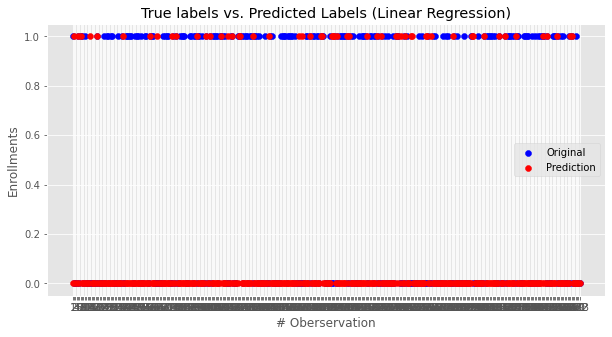

In [59]:
plot_preds(target_test, y_preds, 'Linear Regression')

Decision tree

In [60]:
if __name__ == "__main__":

    dtree = DecisionTreeRegressor(max_depth=5, min_samples_leaf =4, random_state=7)
    dtree.fit(data_train_scaled, target_train)
    y_preds = dtree.predict(data_test_scaled) 
    (rmse, mae, r2)=eval_metrics(target_test, y_preds)

    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)

    
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        # Model registry does not work with file store
    if tracking_url_type_store != "file":

            # Register the model
            # There are other ways to use the Model Registry, which depends on the use case,
            # please refer to the doc for more information:
            # https://mlflow.org/docs/latest/model-registry.html#api-workflow
        mlflow.sklearn.log_model(dtree, "DecisionTreeRegressor", registered_model_name="DecisionTreeRegressor")
    else:
        mlflow.sklearn.log_model(dtree, "DecisionTreeRegressor")
        print("Model saved in run %s" % mlflow.active_run().info.run_uuid)

  RMSE: 0.5111191089085418
  MAE: 0.4920812850620556
  R2: -0.05132597649032733
Model saved in run 838631ff886a4be89f32eb68569db779


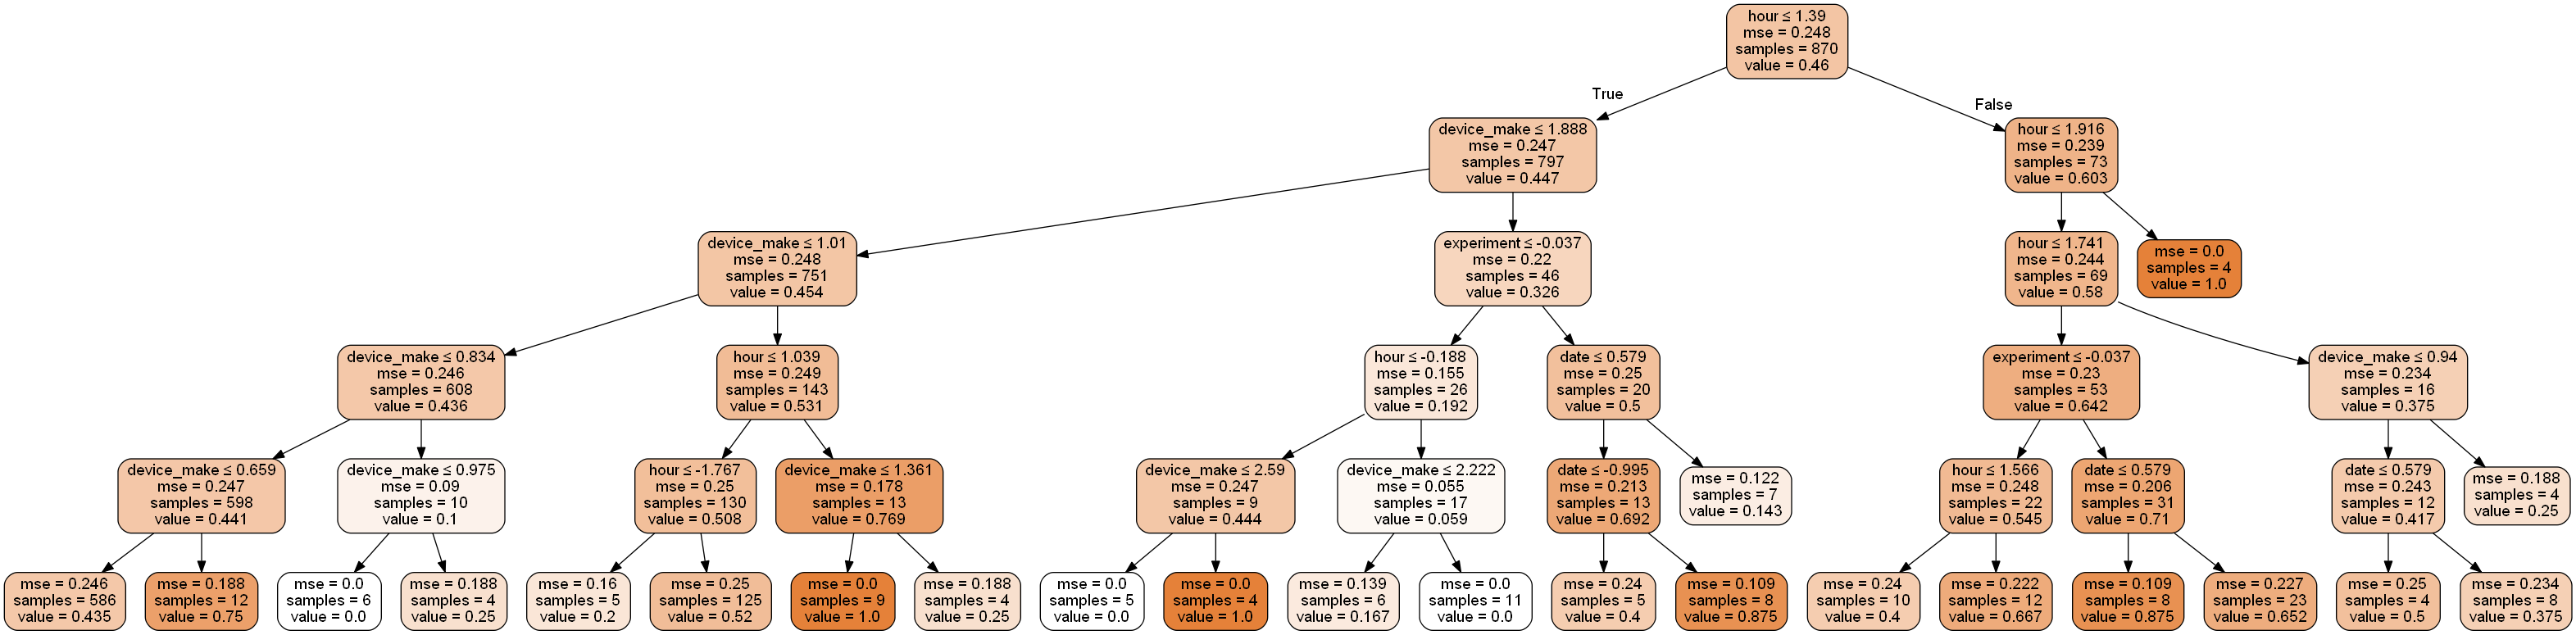

In [61]:
dot_data = StringIO()

export_graphviz(dtree, out_file=dot_data, 
                feature_names=data_train.columns,
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [62]:
if __name__ == "__main__":

    linear_regression = sm.OLS(target_train, data_train)
    linear_regression = linear_regression.fit()
    
    y_preds = linear_regression.predict(data_test)
    (rmse, mae, r2)=eval_metrics(target_test, y_preds)

    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)

    
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        # Model registry does not work with file store
    if tracking_url_type_store != "file":

            # Register the model
            # There are other ways to use the Model Registry, which depends on the use case,
            # please refer to the doc for more information:
            # https://mlflow.org/docs/latest/model-registry.html#api-workflow
        mlflow.sklearn.log_model(linear_regression, "linear_regression", registered_model_name="linear_regression")
    else:
        mlflow.sklearn.log_model(linear_regression, "linear_regression")
        print("Model saved in run %s" % mlflow.active_run().info.run_uuid)

  RMSE: 0.497884412186741
  MAE: 0.4950088177216094
  R2: 0.002414292362735715
Model saved in run 838631ff886a4be89f32eb68569db779


In [63]:
eval_metrics(target_test, y_preds)

(0.497884412186741, 0.4950088177216094, 0.002414292362735715)

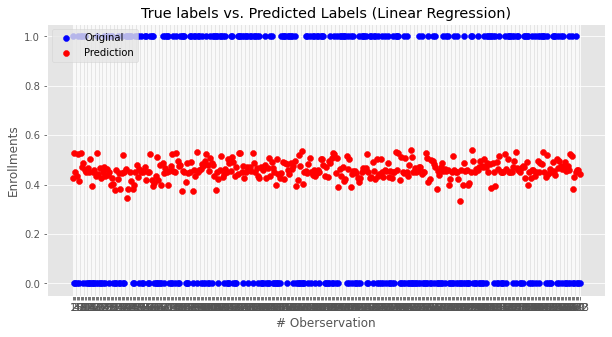

In [64]:
plot_preds(target_test, y_preds, 'Linear Regression')

In [65]:
print(linear_regression.summary())

                                 OLS Regression Results                                
Dep. Variable:                    yes   R-squared (uncentered):                   0.463
Model:                            OLS   Adj. R-squared (uncentered):              0.460
Method:                 Least Squares   F-statistic:                              149.2
Date:                Fri, 23 Jul 2021   Prob (F-statistic):                   3.29e-114
Time:                        21:55:36   Log-Likelihood:                         -625.94
No. Observations:                 870   AIC:                                      1262.
Df Residuals:                     865   BIC:                                      1286.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [66]:
pd.DataFrame(linear_regression.pvalues)\
    .reset_index()\
    .rename(columns={'index':'Terms', 0:'p_value'})\
    .sort_values('p_value')

,Terms,p_value
4,platform_os,2.216102e-12
2,hour,8.766243e-02
0,experiment,1.783475e-01
3,device_make,7.670952e-01
1,date,9.991364e-01


In [67]:
from sklearn.tree import DecisionTreeRegressor

dtree = DecisionTreeRegressor(max_depth=5, min_samples_leaf =4, random_state=7)
dtree.fit(data_train, target_train)
y_preds = dtree.predict(data_test)

eval_metrics(target_test, y_preds)

(0.5111191089085418, 0.4920812850620556, -0.05132597649032733)

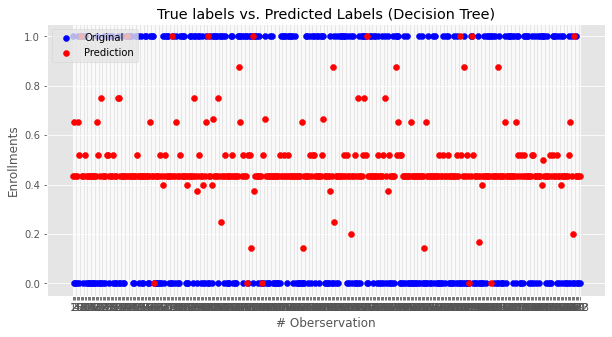

In [68]:

plot_preds(target_test, y_preds, 'Decision Tree')

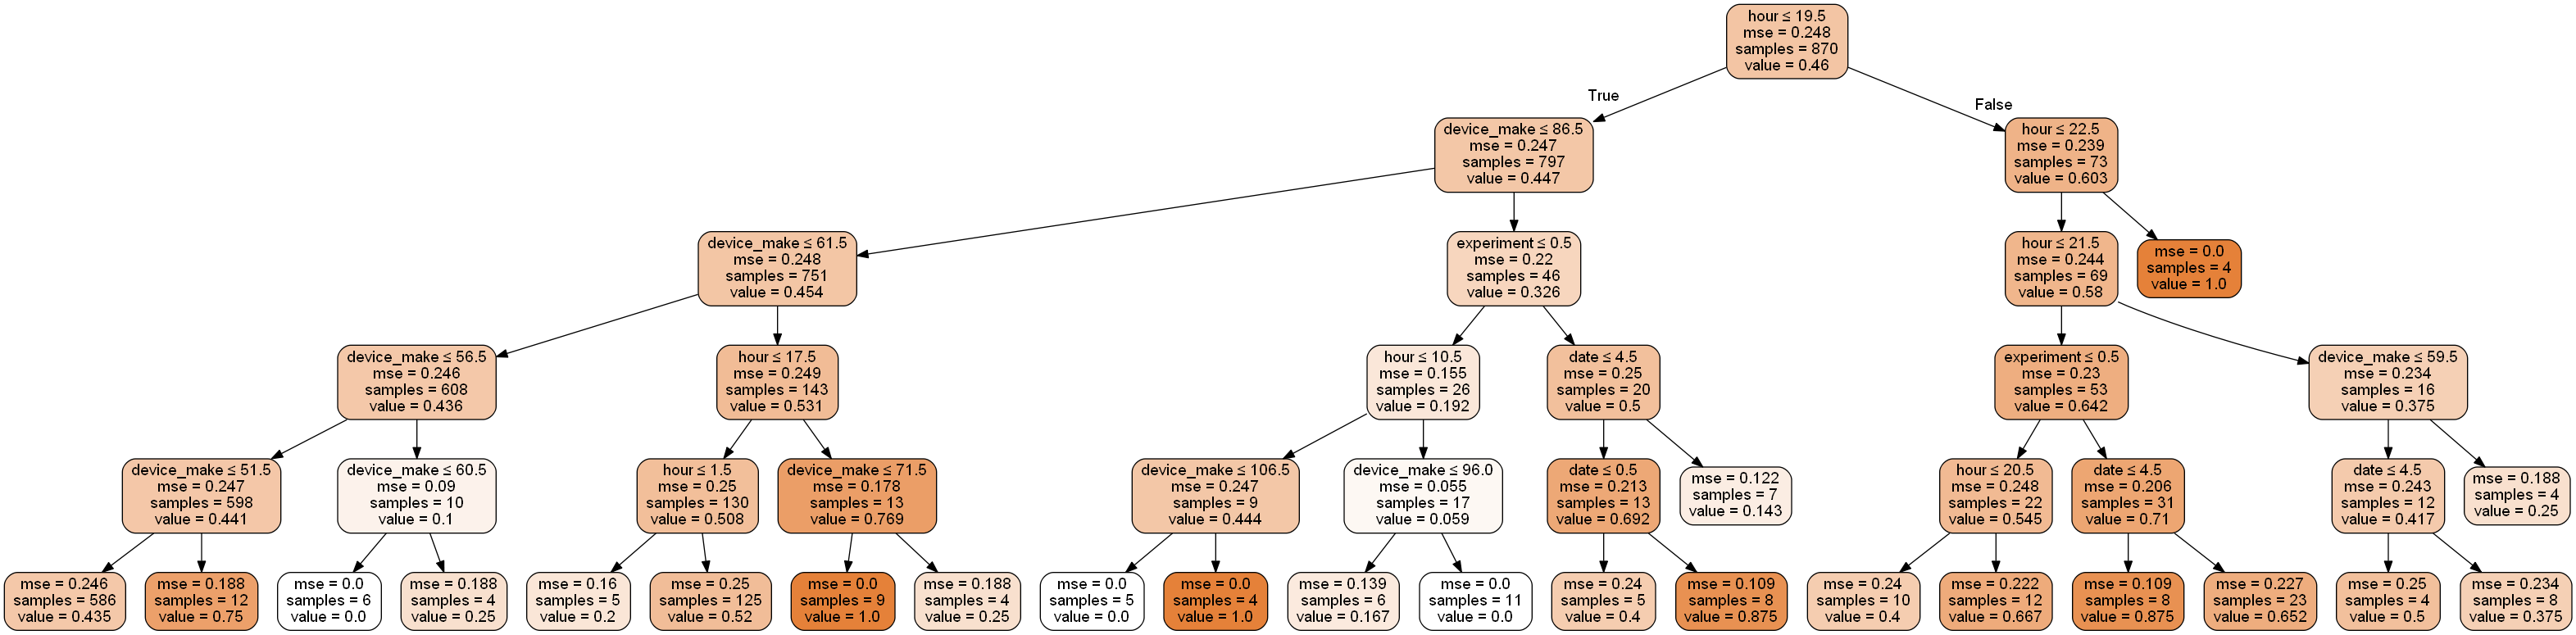

In [69]:
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()

export_graphviz(dtree, out_file=dot_data, 
                feature_names=data_train.columns,
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [70]:

import xgboost as xgb

In [71]:
DM_train = xgb.DMatrix(data=data_train,label=target_train)
DM_test = xgb.DMatrix(data=data_test,label=target_test)

In [72]:
parameters = {
    'max_depth': 6,
    'objective': 'reg:linear',
    'booster': 'gblinear',
    'n_estimators': 1000,
    'learning_rate': 0.2,
    'gamma': 0.01,
    'random_state': 7,
    'subsample': 1.
}

In [73]:
parameters = {
    'max_depth': 6,
    'objective': 'reg:linear',
    'booster': 'gblinear',
    'n_estimators': 1000,
    'learning_rate': 0.2,
    'gamma': 0.01,
    'random_state': 7,
    'subsample': 1.
}

In [74]:
xg_reg = xgb.train(params = parameters, dtrain=DM_train, num_boost_round=8)
y_preds = xg_reg.predict(DM_test)

[21:55:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[21:55:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "gamma", "max_depth", "n_estimators", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




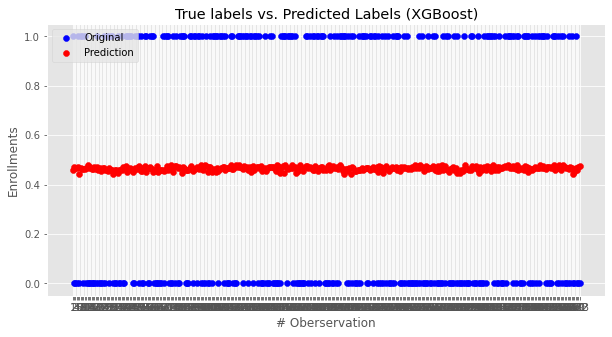

In [75]:
plot_preds(target_test, y_preds, 'XGBoost')